# Questions

In this notebook I am going to use the Stack Overflow Annual Developer Survey results from 2023 to answer the following questions:

1. What is the most common form of employment among the participants of the survey?
2. What is the most lucrative developer type?
3. Is there any correlation between work experience and compensation?

To begin, let's read in the libraries that will help prepare and visualise the answers together with the dataset.

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('survey_results_public_2023.csv')
df.head()

,ResponseId,Q120,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I agree,None of these,18-24 years old,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I agree,I am a developer by profession,25-34 years old,"Employed, full-time",Remote,Hobby;Contribute to open-source projects;Boots...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;Friend or fam...,Formal documentation provided by the owner of ...,...,1-2 times a week,10+ times a week,Never,15-30 minutes a day,15-30 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,285000.0
2,3,I agree,I am a developer by profession,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby;Professional development or self-paced l...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Formal documentation provided by the owner of ...,...,6-10 times a week,6-10 times a week,3-5 times a week,30-60 minutes a day,30-60 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,250000.0
3,4,I agree,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Colleague;Friend or family member;Other online...,Formal documentation provided by the owner of ...,...,1-2 times a week,10+ times a week,1-2 times a week,15-30 minutes a day,30-60 minutes a day,Automated testing;Continuous integration (CI) ...,NaN,Appropriate in length,Easy,156000.0
4,5,I agree,I am a developer by profession,25-34 years old,"Employed, full-time;Independent contractor, fr...",Remote,Hobby;Contribute to open-source projects;Profe...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Online Courses or Certi...,Formal documentation provided by the owner of ...,...,1-2 times a week,1-2 times a week,3-5 times a week,60-120 minutes a day,30-60 minutes a day,Microservices;Automated testing;Observability ...,Other,Appropriate in length,Neither easy nor difficult,23456.0


To answer the first question: What is the most common form of employment among the participants of the survey? I am going to look at the Employment field, to see what form of employment the individuals declared. 

In [2]:
schema = pd.read_csv('survey_results_schema_2023.csv')
list(schema[schema['qname'] == 'Employment']['question'])[0]

'Which of the following best describes your current employment status? Select all that apply.'

In [3]:
# Let's look at some sample answers in the Employment field
employment = df['Employment'].value_counts().reset_index()
employment.head()

,index,Employment
0,"Employed, full-time",53748
1,"Student, full-time",7430
2,"Independent contractor, freelancer, or self-em...",7076
3,"Employed, full-time;Independent contractor, fr...",4354
4,"Not employed, but looking for work",2553


In [4]:
# The mean of nulls
df['Employment'].isnull().mean()

0.01441962683889487

The employment column has very few missing values. This is a categorical column, so I am going to use the mode to fill those in.

In [5]:
df['Employment'].fillna(df['Employment'].mode()[0], inplace=True)

In [6]:
# And the value counts of each possible answer
employment = df['Employment'].value_counts().reset_index()#Provide a pandas series of the counts for each CousinEducation status
employment.rename(columns={'index': 'method', 'Employment': 'count'}, inplace=True)
employment.head()

,method,count
0,"Employed, full-time",55034
1,"Student, full-time",7430
2,"Independent contractor, freelancer, or self-em...",7076
3,"Employed, full-time;Independent contractor, fr...",4354
4,"Not employed, but looking for work",2553


Because a participant could have provided more than one answer in the Employment field, I decided to create a list of all of the possible forms of employment they could have selected.

In [7]:
possible_vals = ["Employed, full-time", "Independent contractor, freelancer, or self-employed", 
                 "Student, full-time", "Employed, part-time", "Not employed, but looking for work",
                 "Student, part-time", "Not employed, and not looking for work", "Retired",
                 "I prefer not to say"]

In [8]:
def clean(df):
    '''
    INPUT 
        df - a dataframe holding the Employment column
        
    OUTPUT
        props_employment_df - a dataframe with the count of different forms of occupation
    '''
    dict = {"Employed, full-time": 0, 
            "Independent contractor, freelancer, or self-employed": 0, 
            "Student, full-time": 0, 
            "Employed, part-time": 0, 
            "Not employed, but looking for work": 0, 
            "Student, part-time": 0, 
            "Not employed, and not looking for work": 0, 
            "Retired": 0,
            "I prefer not to say": 0}
    
    for val in possible_vals:
        for idx in range(df.shape[0]):
            if val in df['method'][idx]:
                dict[val] += int(df['count'][idx])
    print(dict)
    new_df = pd.DataFrame.from_dict(list(dict.items()))
    new_df.columns = ['Occupation Type', 'Count']
    new_df.sort_values('Count', ascending=False, inplace=True)
    new_df.set_index('Occupation Type', inplace=True)
    return new_df
    
method_counts_df = clean(employment)
method_counts_df.head()

{'Employed, full-time': 62185, 'Independent contractor, freelancer, or self-employed': 13988, 'Student, full-time': 11768, 'Employed, part-time': 5029, 'Not employed, but looking for work': 4178, 'Student, part-time': 3390, 'Not employed, and not looking for work': 1380, 'Retired': 737, 'I prefer not to say': 549}


,Count
Occupation Type,
"Employed, full-time",62185
"Independent contractor, freelancer, or self-employed",13988
"Student, full-time",11768
"Employed, part-time",5029
"Not employed, but looking for work",4178


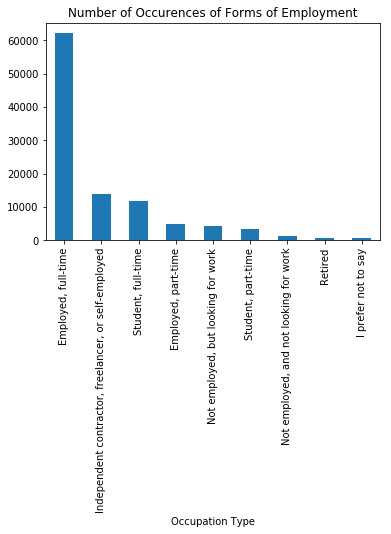

In [9]:
method_counts_df.plot(kind='bar', legend=None);
plt.title('Number of Occurences of Forms of Employment');
plt.show()

Here you can see in descending order the prevalence of each form of employment as selected by the participants (one person could have selected multiple options). The clear leaders are Employed, full-time and Independent contractor, freelancer, or self-employed.

Less than 12% of respondents are pursuing full-time education and only 4% are not employed, but looking for work. There are a number of individuals who have already retired or are not employed, but not looking for work.

Moving on to the second question: What is the most lucrative developer type? Let's start by looking the  ```ConvertedCompYearly``` column that contains the converted yearly salaries.

In [10]:
df['ConvertedCompYearly']

0             NaN
1        285000.0
2        250000.0
3        156000.0
4         23456.0
5         96828.0
6        135000.0
7         80000.0
8         64254.0
9             NaN
10            NaN
11        78003.0
12        75000.0
13       150000.0
14       187407.0
15       107090.0
16        45149.0
17        58899.0
18           14.0
19        75010.0
20        60828.0
21        85672.0
22       120000.0
23        69608.0
24        37481.0
25       103743.0
26            NaN
27            NaN
28        38483.0
29        74963.0
           ...   
89154     75000.0
89155     63199.0
89156    195000.0
89157    319711.0
89158     52981.0
89159         NaN
89160     28625.0
89161         NaN
89162     50719.0
89163         NaN
89164         NaN
89165         NaN
89166     16917.0
89167     15752.0
89168         NaN
89169         NaN
89170     64254.0
89171     61041.0
89172         NaN
89173         NaN
89174         NaN
89175         NaN
89176         NaN
89177         NaN
89178     

In [11]:
# The mean of nulls for converted yearly compensation
df['ConvertedCompYearly'].isnull().mean()

0.46157382490132759

In [12]:
# Counting the number of non-null values
df['ConvertedCompYearly'].count()

48019

The ConvertedCompYearly yearly comlumn has over 46% missing values, however we still get 48019 records. I decided not to fill in the missing values to show what the earnings of the 48019 looked like exactly.

In [13]:
# The mean of nulls for developer type
df['DevType'].isnull().mean()

0.13805166846071043

The DevType column has very few missing values. This is a categorical column, so I am going to use the mode to fill those in.

In [14]:
df['DevType'].fillna(df['DevType'].mode()[0], inplace=True)

Grouping by Developer Type, what is the mean converted yearly compensation? I am removing nulls as I am only interested in actual values provided by survey participants in both fields.

In [15]:
compensation_df = df.groupby(['DevType']).median()['ConvertedCompYearly'].sort_values(ascending=False).dropna()
compensation_df.head()

DevType
Senior Executive (C-Suite, VP, etc.)    124753.5
Engineering manager                     124138.0
Marketing or sales professional         116000.0
Engineer, site reliability              115657.0
Developer Experience                    107090.0
Name: ConvertedCompYearly, dtype: float64

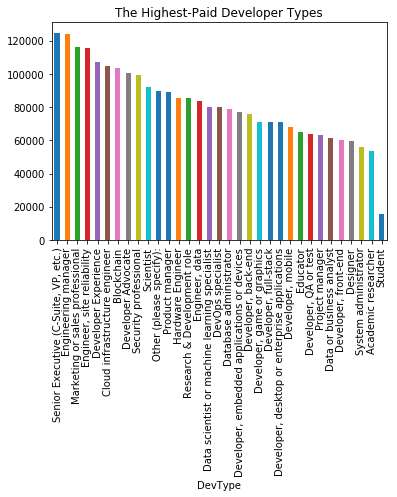

In [16]:
compensation_df.plot(kind='bar', legend=None);
plt.title('The Highest-Paid Developer Types');
plt.show()

Looking at the chart above, my initial assumption related to managerial roles being tied to higher earnings proved to be true. Senior Executives and Engineering managers are among the top 5 developer types. Interestingly, Blockchain technologies offer even higher paychecks.

What stands out is the Developer Experience career path followed only by a relatively small number of respondents (326) with mean converted total compensation just above $301k. Maybe that is a niche worth exploring?

Finally, I would like to look into the question of correlation between salary and work experience. To do that, I am going to use the pandas  ```DataFrame.corr() ``` function that computes pairwise correlation of columns, excluding any null values, and visualise the results as a heatmap.

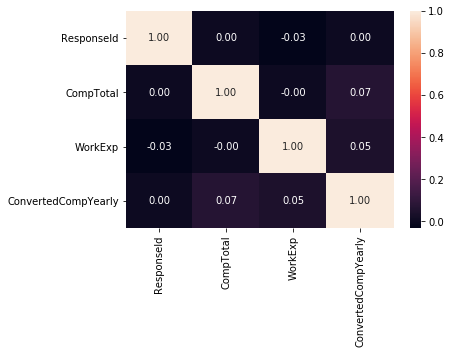

In [17]:
sns.heatmap(df.corr(), annot=True, fmt=".2f");

Surprisingly, based on the data, there is only a very insignificant or negligible positive correlation between work experience and converted yearly compensation.